<a href="https://colab.research.google.com/github/robertomoragad/Estadistica/blob/master/Montecarlo_equipo_delivery_producto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Caso de uso - Simulación Montecarlo para equipos de *delivery*

##Introducción

En este artículo se describirá un ejemplo práctico de la aplicación de la simulación Montceralo para:

1. Proyectar la cantidad de funcionalidades que pueden ser entregadas en una cantidad acotada de semanas adicionales.
2. Proyectar la cantidad de semanas necesarias para entregar una cantidad acotada de funcionalidades adicionales.


Para realizar esto, es necesario contar con un histórico de la cantidad de funcionalidades entregdas por semana de la organización. En este caso se cuenta con un dataset de las últimas 6 semanas, donde la variable "Velocidad" corresponde a la cantidad de funcionalidades implementadas por el equipo de producto.

Aquí el dataset:

| Semana | Velocidad |
|--------|-----------|
| 24     | 3         |
| 25     | 8         |
| 26     | 11        |
| 27     | 10        |
| 28     | 11        |
| 29     | 9         |

##Análisis exploratorio del dataset

Para este fin es necesario conectarse a la base de datos donde el equipo de Producto registra sus métricas de entrega, este instrumento es una simple planilla online de Google Sheet.  Se necesita cargar librerias e importar la nube donde se encuentra el dataset:

In [1]:
#Importamos las Librerías para análisis

import numpy as np # import numpy
from scipy import stats # import scipy.stats
import matplotlib.pyplot as plt #import matplotlib
import pandas as pd #import pandas (dataframe)
import random

In [99]:
#Importar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
#Importar Google Sheet
from google.colab import auth
import gspread
from google.auth import default
#autenticando en google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

#definiendo el worksheet
worksheet = gc.open('BBDD_leadtime_kanban').sheet1
#get_all_values gives a list of rows
rows = worksheet.get_all_values()
#Converttir a DataFrame (pandas)
df = pd.DataFrame(rows)

#read 
df.head()

,0,1,2,3,4,5,6,7,8
0,ID,Funcionalidad,Tipologia,Fecha_seleccionada,Fecha_done,Leadtime,Semana_seleccionado,Semana_done,Satisfaccion
1,BC97,BC24,Eficiencia,24/06/2019,25/06/2019,2,26,26,4
2,Cu58,Cu138,Eficiencia,04/07/2019,06/07/2019,3,27,27,4
3,PP362,PP66,Eficiencia,26/06/2019,27/06/2019,2,26,26,5
4,IQ30,IQ169,Eficiencia,03/07/2019,05/07/2019,3,27,27,5


In [132]:
#creando los nombre de columna (run only once)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [133]:
#leer dataframe (df)
df.tail()

,ID,Funcionalidad,Tipologia,Fecha_seleccionada,Fecha_done,Leadtime,Semana_seleccionado,Semana_done,Satisfaccion
53,PP33,PP277,Growth,18/07/2019,,,29,,
54,PP208,PP19,Growth,19/07/2019,,,29,,
55,PP53,PP112,Growth,20/07/2019,,,29,,
56,PP149,PP212,Growth,21/07/2019,,,29,,
57,PP377,PP354,Growth,21/07/2019,,,29,,


In [134]:
#check data types (float, string, date,.. )
print(df.dtypes)

0
ID                     object
Funcionalidad          object
Tipologia              object
Fecha_seleccionada     object
Fecha_done             object
Leadtime               object
Semana_seleccionado    object
Semana_done            object
Satisfaccion           object
dtype: object


In [135]:
#Reemplazar registros sin fecha por 'NaN'
df['Fecha_done'] = df['Fecha_done'].replace('', 'NaN')

In [137]:
#transformar tipos de datos

df['Leadtime'] = pd.to_numeric(df['Leadtime'])
df['Semana_seleccionado'] = pd.to_numeric(df['Semana_seleccionado'])
df['Semana_done'] = pd.to_numeric(df['Semana_done'])
df['Satisfaccion'] = pd.to_numeric(df['Satisfaccion'])
df['Fecha_done'] = pd.to_datetime(df['Fecha_done'], format='%d/%m/%Y')
df['Fecha_seleccionada'] = pd.to_datetime(df['Fecha_seleccionada'], format='%d/%m/%Y')

print(df.dtypes)
df.tail()

0
ID                             object
Funcionalidad                  object
Tipologia                      object
Fecha_seleccionada     datetime64[ns]
Fecha_done             datetime64[ns]
Leadtime                      float64
Semana_seleccionado             int64
Semana_done                   float64
Satisfaccion                  float64
dtype: object


,ID,Funcionalidad,Tipologia,Fecha_seleccionada,Fecha_done,Leadtime,Semana_seleccionado,Semana_done,Satisfaccion
53,PP33,PP277,Growth,2019-07-18,NaT,NaN,29,NaN,NaN
54,PP208,PP19,Growth,2019-07-19,NaT,NaN,29,NaN,NaN
55,PP53,PP112,Growth,2019-07-20,NaT,NaN,29,NaN,NaN
56,PP149,PP212,Growth,2019-07-21,NaT,NaN,29,NaN,NaN
57,PP377,PP354,Growth,2019-07-21,NaT,NaN,29,NaN,NaN


Ahora que ya se cuenta con el dataset cargado y curado, se procede a calcular la cantidad de funcionalidades entregadas/implementadas por semana por el equipo de producto de la organización estudiada:

In [138]:
#Tabla dinamica para conocer la cantidad de funcionalidades entregadas por semana (done)
table1 = pd.pivot_table(df,index=['Semana_done'],values=['Funcionalidad'],aggfunc=np.size)
table1

,Funcionalidad
Semana_done,
24.0,3
25.0,8
26.0,11
27.0,10
28.0,11
29.0,9


Ahora se procede a calcular la cantidad de funcionalidades seleccionadas para desarrollar por semana, por el equipo de producto de la organización estudiada:

In [139]:
#Tabla dinamica para conocer la cantidad de funcionalidades seleccionadas para desarrollar por semana (to-do)
table2 = pd.pivot_table(df,index=['Semana_seleccionado'],values=['Funcionalidad'],aggfunc=np.size)
table2

,Funcionalidad
Semana_seleccionado,
23,2
24,3
25,8
26,13
27,11
28,10
29,10


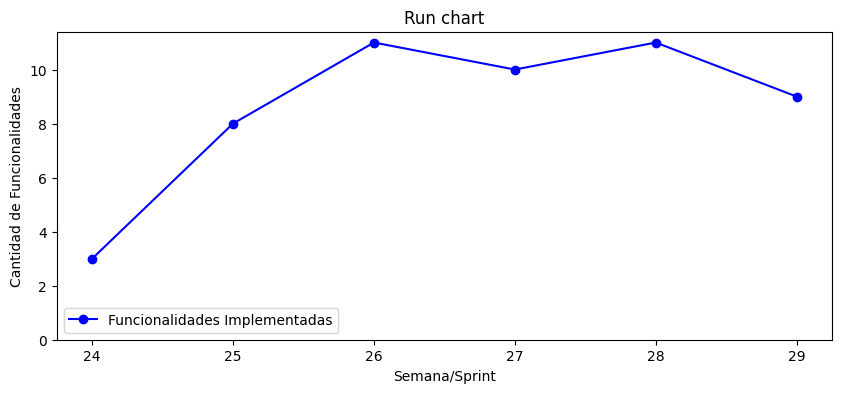

In [140]:
# Graficando un Run chart de la velocidad
plt.figure(figsize=(10, 4))
# Obtener los valores de la columna 'Funcionalidad' de la tabla pivote
func_implement = table1['Funcionalidad']
# Crear una lista de semanas para el eje x
semanas = table1.index
# Crea el gráfico Run chart
plt.plot(semanas, func_implement, marker='o', linestyle='-', color='blue', label="Funcionalidades Implementadas")
plt.ylim(bottom=0)
#títulos y etiquetas de los ejes
plt.title('Run chart')
plt.xlabel('Semana/Sprint')
plt.ylabel('Cantidad de Funcionalidades')
plt.legend()
plt.show()

Ahora se calculará la media y la desviación estándar de la velocidad semanal:

In [141]:
media = np.mean(table1.Funcionalidad)
sigma = np.std(table1.Funcionalidad, ddof=1)

print(f'Media: {media: 4.2f}')
print(f'Desviación estándar: {sigma: 4.2f}')

Media:  8.67
Desviación estándar:  3.01


A continuación se realizará un histograma de los tiempos de entrega *End to End* de las funcionalidades.  Adicionalmente se calculará la media y desviación estándar de esta variable.

La media obtenida corresponderá al indicador llamado "Leadtime".

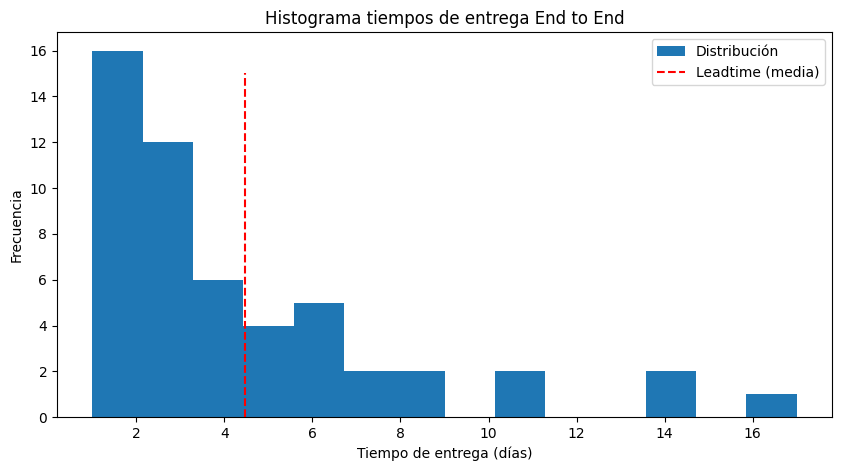

Media:  4.46
Desviación estándar:  3.55


In [142]:
#calcular parametros
leadtime=np.mean(df.Leadtime)#media
sigma= np.std(df.Leadtime, ddof=1)

#Graficar Histograma
plt.figure(figsize=(10, 5))
df.Leadtime.plot(kind='hist', bins=14, label="Distribución")
plt.title('Histograma tiempos de entrega End to End')
plt.xlabel('Tiempo de entrega (días)')
plt.ylabel('Frecuencia')
plt.vlines(leadtime, ymin=0, ymax=15, color="r", linestyle='--', label="Leadtime (media)")
plt.legend()
plt.show()

print(f'Media: {leadtime: 4.2f}')
print(f'Desviación estándar: {sigma: 4.2f}')

La gráfica anterior muestra un histograma con la distribución de los tiempos de entrega de las funcionalidades. Se puede apreciar que los datos no siguen una distribución normal ni simétrica, la variable tiene una sesgo positivo, es probable que la distribución de la variable siga una distribución Gamma o  Exponencial, esto puede ser validado por medio de una prueba de hipótesis.

En promedio el tiempo de entrega de una funcionalidad es de 4.46 días, con una desviación estándar de 3.51 días.

A continuación se realizará un diagram de flujo acumulado considerando la cantidad de funcionalidades seleccionadas para desarrollar y la cantidad de funcionalidades implementadas, ambas variables serán gráficas a nivel de semanas.

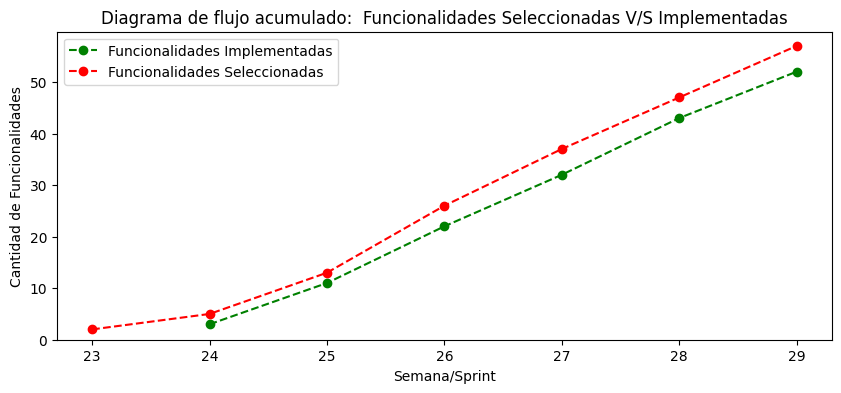

In [143]:
# Graficando un Diagrama de Flujo Acumulado a nivel semanal (sprint)

plt.figure(figsize=(10, 4))
# Obtener los valores de la columna 'Funcionalidad' de la tabla pivote
#resueltos / done
func_implement = table1['Funcionalidad']
func_implement_acumulada = np.cumsum(func_implement)
#seleccionados / to-do
func_selecc = table2['Funcionalidad']
func_selecc_acumulada = np.cumsum(func_selecc)

# Crear una lista de semanas para el eje x
semanas = table1.index
semanas2 = table2.index 

# Crea el gráfico Run chart
plt.plot(semanas, func_implement_acumulada, marker='o', linestyle='--', color='g', label="Funcionalidades Implementadas")
plt.plot(semanas2, func_selecc_acumulada, marker='o', linestyle='--', color='r', label="Funcionalidades Seleccionadas")
plt.ylim(bottom=0)
#títulos y etiquetas de los ejes
plt.title('Diagrama de flujo acumulado:  Funcionalidades Seleccionadas V/S Implementadas')
plt.xlabel('Semana/Sprint')
plt.ylabel('Cantidad de Funcionalidades')
plt.legend()
plt.show()

Del gráfico anterior se puede apreciar que el sistema de trabajo se encuentra muy bien balanceado, esto es visible debido a que las curvas acumuladas de la entrada y salida del sistema mantienen una correlación, lo que es explicado producto de la existencia de Límites de WIP (*work in progress*) y a una práctica de Pull para la toma de trabajo (jalar) por parte del equipo de producto.

Se puede apreciar que la política de Límite de WIP es igual a 5 unidades de funcionalidades en progreso.  Si se considera este valor y se incorpora a la Ley de Little se podrá estimar el leadtime en semanas para la implementación de las funcionalidades.

**Ley de Little:**

* Leadtime = WIP / Throughput

* Leadtime = 5 / 8.67 (func/sem) = 0.576 (semana / funcionalidad)

En promedio una funcionalidad tomará 0.576 semanas para ser implementada, si se quiere traducir a días, dicho valor debe se multiplicado por 7 días.

* Leadtime = 0.576 (semana / funcionalidad) * 7 (días/semana) = **4.04** (días).

En promedio una funcionalidad tomará 4.04 días para ser implementada, este valor es muy similar al obtenido en el calculo de la media muestral de todos los tiempos *End to End* de las funcionalidades implementadas, recordar que este valor fue de **4.46** (días).




Con el siguiente código se realizará un Diagrama de Flujo Acumulado a nivel diario:

In [144]:
#Tabla dinamica para conocer la cantidad de funcionalidades entregadas por día (done)
table3 = pd.pivot_table(df,index=['Fecha_done'],values=['Funcionalidad'],aggfunc=np.size)

#Tabla dinamica para conocer la cantidad de funcionalidades seleccionadas por día (to-do)
table4 = pd.pivot_table(df,index=['Fecha_seleccionada'],values=['Funcionalidad'],aggfunc=np.size)

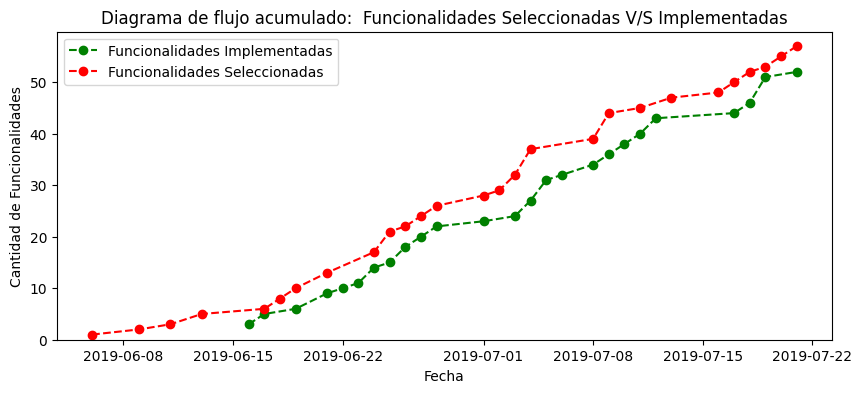

In [145]:
# Graficando un Diagrama de Flujo Acumulado a nivel de día (fecha)

plt.figure(figsize=(10, 4))
# Obtener los valores de la columna 'Funcionalidad' de la tabla pivote
#resueltos / done
func_implement = table3['Funcionalidad']
func_implement_acumulada = np.cumsum(func_implement)
#seleccionados / to-do
func_selecc = table4['Funcionalidad']
func_selecc_acumulada = np.cumsum(func_selecc)

# Crear una lista de semanas para el eje x
dias = table3.index
dias2 = table4.index 

# Crea el gráfico Run chart
plt.plot(dias, func_implement_acumulada, marker='o', linestyle='--', color='g', label="Funcionalidades Implementadas")
plt.plot(dias2, func_selecc_acumulada, marker='o', linestyle='--', color='r', label="Funcionalidades Seleccionadas")
plt.ylim(bottom=0)
#títulos y etiquetas de los ejes
plt.title('Diagrama de flujo acumulado:  Funcionalidades Seleccionadas V/S Implementadas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Funcionalidades')
plt.legend()
plt.show()

##Simulación Montecarlo

La organización está enfrentada a un proceso de lanzamiento de producto en *CiberMonday* que comienza en 5 semanas más, por esta razón el equipo de Producto necesita hacer un pronóstico urgente de la cantidad de funcionalidades que se podrán entregar en 5 semanas más, esto con la finalidad de proyectar si podrán llegar con todas las funcionalidades de Producto diseñadas, o tendrán que priorizar o gestionar sus equipos de trabajo de otra forma.

Recordar que se cuenta con 6 semanas de historia.

In [146]:
# Ingresar velocidad de por semana/sprint
# En este ejemplo tenemos historia de 6 semanas
semana = [24, 25, 26, 27, 28, 29]
velocidad = [3, 8, 11, 10, 11, 9]

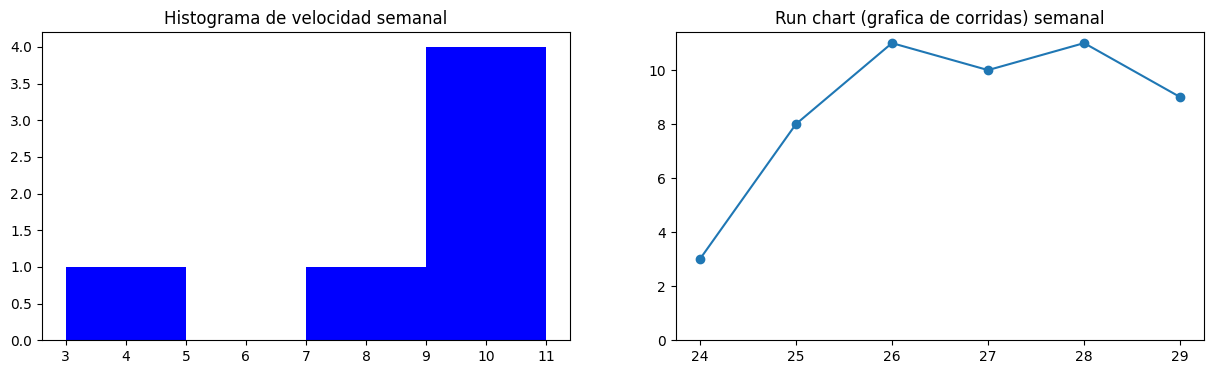


Tamaño muestra:  6
Media:  8.67
Desviación estándar:  3.01


In [147]:
# Graficamos histograma de la velocidad semanal
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].hist(velocidad, bins='auto', density=False, color='b')
ax[0].set_title('Histograma de velocidad semanal')
ax[1].plot(semana, velocidad, marker='o')
ax[1].set_title('Run chart (grafica de corridas) semanal')
ax[1].set_ylim(bottom=0)
plt.show()

# calcular estadísticos
n= np.size(velocidad)
media = np.mean(velocidad)
sigma = np.std(velocidad, ddof=1)

print('\nTamaño muestra: ', n)
print(f'Media: {media: 4.2f}')
print(f'Desviación estándar: {sigma: 4.2f}')

### Paso 1
Definimos nuestros parámetros de simulación

In [148]:
# Se necesita proyectar la cantidad de funcionalidades que se pueden producir en 5 semanas más
# Para tal efecto se deben simular 5 semanas y luego sumar la cantidad de dichas 5 semanas
# Lo anterior se realizará 10.000 veces, es decir, se simularán 10.000 periodos de 5 semanas cada uno

s = 5 # es la cantidad de semanas a simular
m = 1 # es la cantidad de simulaciones a realizar de s semanas

### Paso 2
Para cada simulación de 5 semanas de trabajo, lanzaremos una ruleta que en nuestro caso tiene 6 casilleros; uno por cada semana de historia en nuestro ejemplo. Dependiendo del valor obtenido de la ruleta `[0:6]` iremos a buscar a nuestra historia el valor de 'Funcionalidades completadas' correspondiente. Por ejemplo; si la ruleta nos da un 3, iremos a buscar el valor histórico que está en la posición 3; esto es, 11 funcionalidades.

Los datos que se obtienen de cada simulación los sumamos (esto sería la producción de las 5 semanas) y lo guardaremos en una lista `total`.

In [149]:
n

6

In [150]:
# Crear lista para almacenar sumas de los periodos (s semanas)
total=[] # Crearemos una lista para almacenar la suma de las simulaciones de s semanas
for k in range(0, m):
    suma=0
    for i in range(0, s):
      # Lanzamos la ruleta
      r = random.randint(0, n - 1)
      suma += velocidad[r]
    total.append(suma)
    
print(f'La suma de cantidad de Funcionalidaes para una corrida de simulación es: {total[0]} funcionalidades')

La suma de cantidad de Funcionalidaes para una corrida de simulación es: 48 funcionalidades


Nota: si ejecutas varias veces la celda anterior puedes darte cuenta que los resultados cambian en cada ejecución, esto es producto de lo probabilístico del proceso de la ruleta y de la seleción de los datos desde nuestras semanas históricas.

### Paso 3
Ahora ejecutaremos la misma celda 10.000 veces para reducir los errores que podría generar el tomar una decisión de negocio con una única simulación.

In [151]:
# Cambiamos nuesto m
m = 10000
s = 5 # es la cantidad de semanas a simular

# Crear lista para almacenar sumas de los periodos (s semanas)
total=[] #C rearemos una lista para almacenar la suma de las simulaciones de s semanas
for k in range(0, m):
    suma=0
    for i in range(0, s):
      # Lanzamos la ruleta
      r = random.randint(0, n - 1)
      suma += velocidad[r]
    total.append(suma)
    
print(f'La producción para 10000 corrida de simulación es')
print(f'Replica 1: \t{total[0]}')
print(f'Replica 2: \t{total[1]}')
print(f'Replica 3: \t{total[2]}')
print('...')
print(f'Replica 10000: \t{total[-1]}\n')

print(f'Media de totales: {np.mean(total): 4.2f}')
print(f'Desviación estándar: {np.std(total): 4.2f}')

La producción para 10000 corrida de simulación es
Replica 1: 	48
Replica 2: 	37
Replica 3: 	33
...
Replica 10000: 	41

Media de totales:  43.35
Desviación estándar:  6.11


### Paso 4
Graficamos la distribución de probabilidades de las 10.000 simulaciones.

Vemos que el valor más probable es 44, pero también podría ser 30 o 50.

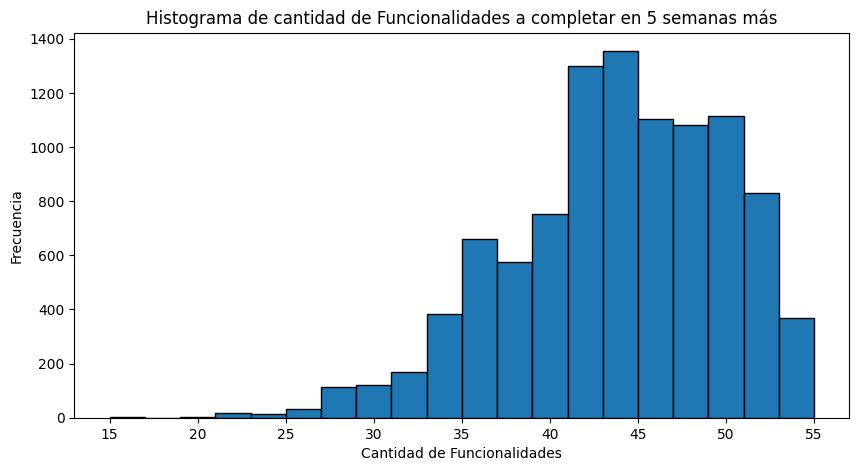

In [165]:
# crear gráfico, con las sumas de las 10.000 simulaciones
plt.figure(figsize=(10, 5))
plt.hist(total, bins=20, edgecolor='black', label='Total', density=False) #con 20  clases fijas
plt.xlabel('Cantidad de Funcionalidades')
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de Funcionalidades a completar en 5 semanas más')
plt.show()

### Paso 5
__Análisis__:

Alguien podría decir que para responder la pregunta solo bastaba con multiplicar la media ($\bar{x} = 8.66$ por la cantidad de semanas ($s=5$), lo cual nos daría una producción esperada de 43 funcionalidades. Sin embargo, veamos la probabilidad que ocurra exactamente ese caso (43 unidades en las próximas 5 semanas).

In [153]:
total.count(43)

667

In [154]:
# Calcular la prob de entregar exactamente 43 unidades en 5 semanas (8.66*5)
prob43 = total.count(43) / m
print(f'Probabilidad de entregar 43 funcionalidades = {prob43:4.2f}')

Probabilidad de entregar 43 funcionalidades = 0.07


Como vemos, la probabilidad de obtener 43 funcionalidades es __solo de un 7%__; la estrategia determinística es de alto riesgo (en este caro es  (1 - 0.07) = 93%).

Para evitar este riesgo, la proyección probabilística con Montecarlo nos invita a determinar una probabilidad de acierto para nuestro pronóstico en la cantidad de funcionalidades a producir. De forma empírica, cuando usamos Montecarlo, buscaremos que la probabilidad de nuestro resultado tenga al menos un 85% de probabilidad de éxito.  Por lo tanto, calcularemos el perceltil 15 el cual representará el valor mínimo de producción para obtener un 85% de seguridad de ocurrencia.

In [156]:
# Es mejor calcular un valor que nos entregue un 85% de seguridad de cumplirse
# Aquí el valor de montecarlo que nos permite ver toda la distribucion de posibles resultados

p15= np.percentile(total, 15)
print('Percentil 15: ',p15)

Percentil 15:  36.0


Con un 85% de deguridad vamos a producir __al menos__ 36 funcionalidades en las próximas 5 semanas. Puede que sean 37, 38, 39, 40 o más, pero al menos serán 36.

##Desafío de negocio

Si la solciitud del negocio es entregar 50 funcionalidades, calcular esa probabilidad:

In [158]:
#prob50 = total.count(50) / m

prob50 = len([num for num in total if num >= 50]) / m

print(f'Probabilidad de entregar al menos 50 funcionalidades = {prob50:4.2f}')

Probabilidad de entregar al menos 50 funcionalidades = 0.17


La proabilidad es muy baja, tanto solo un **17%**. Por lo tanto, si este fuera el caso, la decisión sería ver formas de aumentar la capacidad de producción para llegar al *Cibermonday* con todas las funcionalidades diseñadas para tal evento.

##Gráficas acumuladas y Montecarlo

###Cantidad de funcionalidades

A continuación se desarrollarán una serie de gráficos para visualizar la velocidad histórica del equipo de producto de forma acumulada, junto con la proyección de entrega de funcionalidades para la semana número 34 (5 semanas adicionales) que fue obtenida producto de 10,000 simulaciones con el procedimiento Montecarlo ejecuado anteriormente.

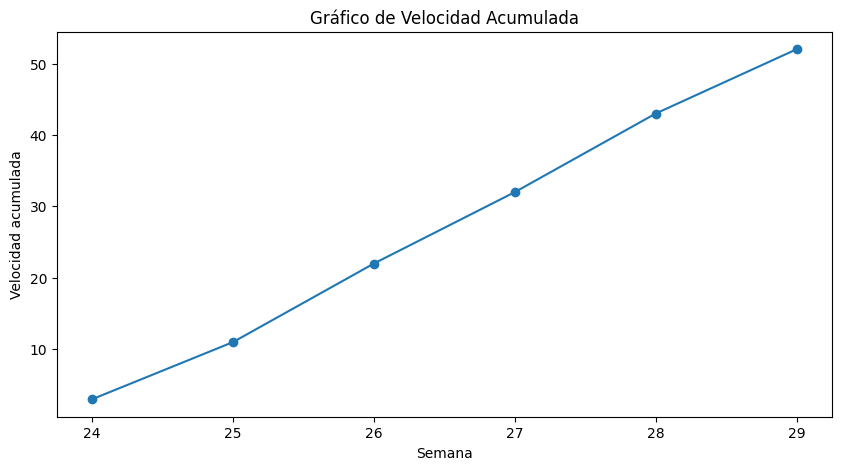

In [159]:
# Graficamos histograma de la velocidad semanal acumulada
semana = [24, 25, 26, 27, 28, 29]
velocidad = [3, 8, 11, 10, 11, 9]
velocidad_acumulada = np.cumsum(velocidad)

plt.figure(figsize=(10, 5))
plt.plot(semana, velocidad_acumulada, marker='o')
plt.xlabel('Semana')
plt.ylabel('Velocidad acumulada')
plt.title('Gráfico de Velocidad Acumulada')
plt.show()


Ahora se construirán 2 gráficas, a la izquierda el gráfico con la velocidad acumulada de las semanas históricas, junto con la proyección acumulada a la semana 34 luego de ejecutar 10,000 simulaciones.

A la derecha se crea un gráfico con un histograma de orientación horizontal para visualizar de mejor forma la distribución de la cantidad de funcionalidades acumuladas que pueden ser entregadas en la semana número 34.

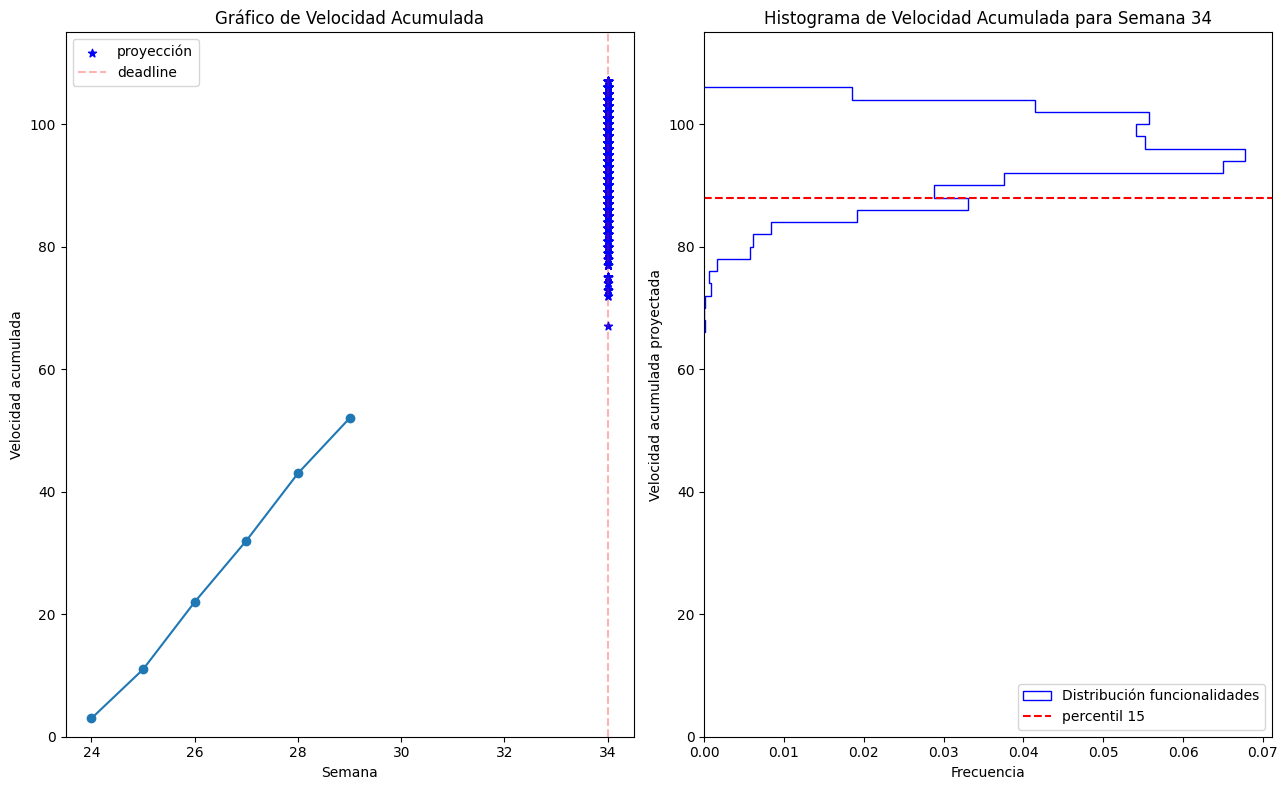

Percentil 15 =  88.0


In [163]:
#dataset
semana = [24, 25, 26, 27, 28, 29]
velocidad = [3, 8, 11, 10, 11, 9]
velocidad_acumulada = np.cumsum(velocidad)

# Generar 10000 valores de simulación Montecarlo para la semana 34
semana_34 = [34] * 10000
velocidad_simulacion = [x + 52 for x in total]
p15 = np.percentile(velocidad_simulacion, 15) #percentil 15 de la proyección acum a la semana 34

# Crear los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8))

# Gráfico de velocidad acumulada
ax1.plot(semana, velocidad_acumulada, marker='o')
ax1.scatter(semana_34, velocidad_simulacion, marker='*', color='b', label="proyección")
ax1.set_ylim(bottom=0)
ax1.set_ylim(top=115)
ax1.set_xlabel('Semana')
ax1.set_ylabel('Velocidad acumulada')
ax1.set_title('Gráfico de Velocidad Acumulada')
ax1.axvline(x=34, color='r', linestyle='--', label="deadline", alpha=0.3)
ax1.legend()

# Histograma de velocidad para la semana 34 (invertido)
ax2.hist(velocidad_simulacion, bins=20, density=True, color='b',histtype='step', align='left', orientation='horizontal', label="Distribución funcionalidades")
ax2.set_ylim(bottom=0)
ax2.set_ylim(top=115)
ax2.set_xlabel('Frecuencia')
ax2.set_ylabel('Velocidad acumulada proyectada')
ax2.set_title('Histograma de Velocidad Acumulada para Semana 34')
# Agregar línea horizontal en el histograma con percentil 15
ax2.axhline(y=p15, color='r', linestyle='--', label="percentil 15")
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()


print('Percentil 15 = ', p15)

**Conclusión:**

Se concluye que con un 85% de seguridad para la semana número 34, el equipo de Producto tendrá implementado al menos 88 funcionalidades, es decir, 36 funcionalidades adicionales a las 52 que ya ha implementado en la semana número 29.

Hasta aquí se ha visto un análisis y procedimiento estadístico para responder la primera pregunta establecida al inicio de este documento:

1. Proyectar la cantidad de funcionalidades que pueden ser entregadas en una cantidad acotada de semanas adicionales.


###Cantidad de semanas necesarias

En esta sección se presentará un procedimiento adicional para responder la segunda pregunta planteada:
2. Con base en la velocidad histórica de 6 semanas, proyectar la cantidad de semanas adicionales necesarias para entregar una cantidad de acotada de funcionalidades adicionales.

Para fines de ejemplificar el ejercicio, imaginar que el equipo de Producto se encuentra en la semana 29 y ya ha implementado 52 funcionalidades, pero necesita completar un alcance (Scope) de producto igual a 83 funcionalidades, es decir, les falta el desarrollo e implementación de 31 funcionalidades adicionales.  La pregunta en que se necesita responder es:

¿en cuántas semanas adicionales, el equipo de Producto podrá completar el Scope de 83 funcionalidades?

A continuación se desarrolla un código y análisis para responder esta pregunta:

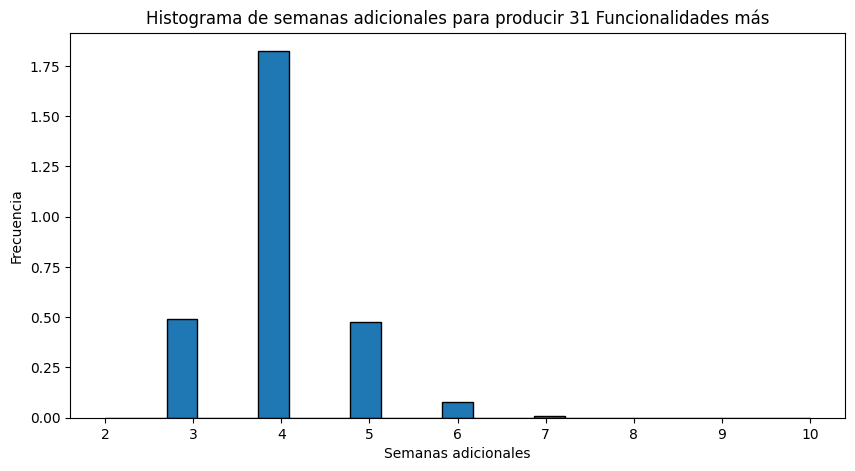

Percentil 15:  5.0


In [173]:
#cargar dataset
velocidad = [3, 8, 11, 10, 11, 9]
produccion_actual = sum(velocidad)
num_simulaciones = 10000
funcionalidades_adicional = 31

semanas_adicionales = []

for _ in range(num_simulaciones):
    produccion_simulada = produccion_actual
    semanas = 0

    while produccion_simulada < produccion_actual + (funcionalidades_adicional):
        produccion_simulada += random.choice(velocidad)
        semanas += 1

    semanas_adicionales.append(semanas)

# Crear el histograma
plt.figure(figsize=(10, 5))
plt.hist(semanas_adicionales, bins='auto', edgecolor='black', range=[2, 10], density=True)
plt.xlabel('Semanas adicionales')
plt.ylabel('Frecuencia')
plt.title('Histograma de semanas adicionales para producir 31 Funcionalidades más')
plt.show()

#calcular percentil 85
p85= np.percentile(semanas_adicionales, 85)
print('Percentil 15: ',p85)

**Conclusión:**

Con una seguridad del 85%, el equipo de Producto necesitará a lo más 5 semanas adicionales para entregar las 31 funcionalidades faltantes.

Ahora se construirán 2 gráficas, abajo el gráfico con la velocidad acumulada de las semanas históricas, junto con la proyección de la semana dónde se podrá completar la implementación del Scope (83 funcionalidades), luego de ejecutar las 10,000 simulaciones.

Arriba se crea un gráfico con un histograma de orientación vertical para visualizar de mejor forma la distribución de la cantidad de semanas necesarias para completar un acumulado de 83 funcionalidades.

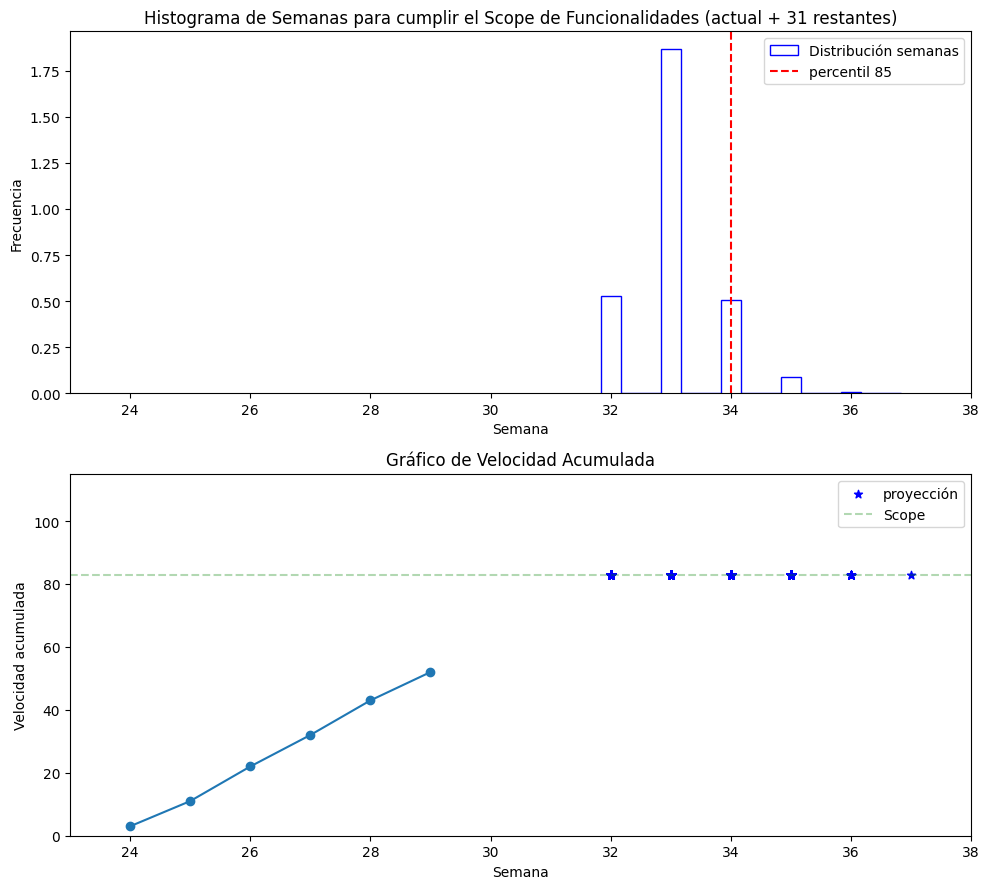

Percentil 85 =  34.0


In [172]:
#dataset
semana = [24, 25, 26, 27, 28, 29]
velocidad = [3, 8, 11, 10, 11, 9]
velocidad_acumulada = np.cumsum(velocidad)

funcionalidades_adicional = 31
scope = np.sum(velocidad) + funcionalidades_adicional

# Generar 10000 valores de simulación Montecarlo para la semana 34
q_func_scope = [scope] * 10000
semana_simulacion = [x + 29 for x in semanas_adicionales]
p85 = np.percentile(semana_simulacion, 85)

# Crear los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))

# Gráfico de velocidad acumulada
ax2.plot(semana, velocidad_acumulada, marker='o')
ax2.scatter(semana_simulacion, q_func_scope, marker='*', color='b', label="proyección")
ax2.set_xlim(left=23)
ax2.set_xlim(right=38)
ax2.set_ylim(bottom=0)
ax2.set_ylim(top=115)
ax2.set_xlabel('Semana')
ax2.set_ylabel('Velocidad acumulada')
ax2.set_title('Gráfico de Velocidad Acumulada')
ax2.axhline(y=scope, color='g', linestyle='--', label="Scope", alpha=0.3)
ax2.legend()

# Histograma de velocidad para la semana 34 (invertido)
ax1.hist(semana_simulacion, bins="auto", density=True, histtype='step', align='left', color='b', orientation='vertical', label="Distribución semanas",  )
ax1.set_xlim(left=23)
ax1.set_xlim(right=38)
ax1.set_xlabel('Semana')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Histograma de Semanas para cumplir el Scope de Funcionalidades (actual + 31 restantes)')
#Agregar línea vertical en el histograma con percentil 85
ax1.axvline(x=p85, color='r', linestyle='--', label="percentil 85")
ax1.legend()

plt.tight_layout()
plt.show()

print('Percentil 85 = ', p85)

**Conclusión:**

Se concluye que con un 85% de seguridad que para completar un Scope igual a 83 funcionalidades, a lo más estás estarán impletadas en la semana número 34, es decir, en 5 semanas más que la semana actual número 29.